Aegean assumes Gaussian noise. Polarised intensity has Ricean noise. How does this affect source finding?

To answer this question we'll simulate some Gaussian sources with both Gaussian and Ricean noise, and run Aegean on them.

In [9]:
import astropy.convolution
import matplotlib.pyplot as plt
import numpy
import healpy
import AegeanTools.source_finder as aegean_source

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/healpy/_query_disc.cpython-37m-darwin.so, 2): Symbol not found: __ZN14T_Healpix_BaseIlE8SetNsideEl23Healpix_Ordering_Scheme
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/healpy/_query_disc.cpython-37m-darwin.so
  Expected in: flat namespace
 in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/healpy/_query_disc.cpython-37m-darwin.so

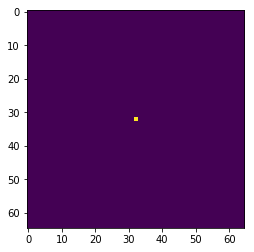

In [2]:
base_image = numpy.zeros((65, 65))
base_image[32, 32] = 1

plt.imshow(base_image)

In [3]:
gaussian_sigmas = numpy.linspace(1, 10, 16)  # px
gaussian_images = numpy.array(
    [astropy.convolution.convolve(base_image, astropy.convolution.Gaussian2DKernel(s))
     for s in gaussian_sigmas])

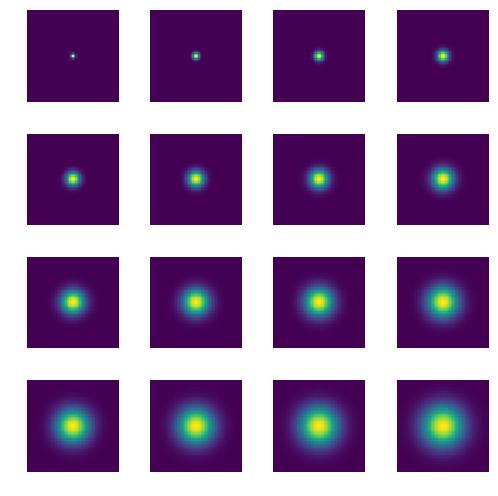

In [4]:
plt.figure(figsize=(7, 7))
for i, im in enumerate(gaussian_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

In [5]:
ricean_images = gaussian_images ** 2

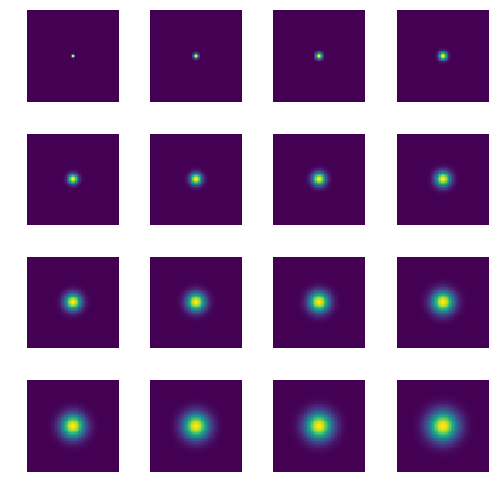

In [6]:
plt.figure(figsize=(7, 7))
for i, im in enumerate(ricean_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

With some simple source images, we can now run Aegean on them.

<module 'AegeanTools' from '/Users/alger/repos/Aegean/AegeanTools/__init__.py'>